# Step 1 Loading Data

In [2]:
import numpy as np

In [3]:
# load the clean and noisy data
# sample data: -59	-55	-62	-64	-68	-77	-86	1
# the last number is the label

clean_data = np.loadtxt("./wifi_db/clean_dataset.txt")
noisy_data = np.loadtxt("./wifi_db/noisy_dataset.txt")

print(clean_data.shape, noisy_data.shape)

(2000, 8) (2000, 8)


# Tree building

So we now build the tree, following the spec, each node has attributes: 

```
{"attribute", "value", "left", "right", "leaf"}
```

In [4]:
import numpy as np

class Node:
  def __init__(self, attribute, value, left=None, right=None, leaf=False):
    self.attribute = attribute
    self.value = value
    self.left = left
    self.right = right
    self.leaf = leaf


def get_entropy(dataset):
    # get the count for each label
    labels, counts = np.unique(dataset[:, -1], return_counts=True)
    # turn count to probs
    probs = counts / np.sum(counts)
    # recall H(d) = \sum_{k=1}^{k=K}p_k*\log_2(p_k)
    return -np.sum(probs * np.log2(probs + 1e-9))  # the 1e-9 avoids log(0)


def find_split(dataset):
    # we -1 since last col is label
    num_data, num_features = dataset.shape[0], dataset.shape[1] - 1
    # dummy init
    best_feature = None
    best_threshold = None
    best_left_split = None
    best_right_split = None
    min_entropy = float('inf')
    # iterate all the features
    for i in range(num_features):
        # as per spec, sort it, note this sort in increasing order
        sorted_dataset = dataset[dataset[:, i].argsort()]
        # traverse to find the best splitting point
        for j in range(1, num_data - 1):
            left_split, right_split = sorted_dataset[:j, :], sorted_dataset[j:, :]
            l_entropy = get_entropy(left_split)
            r_entropy = get_entropy(right_split)
            total_entropy = (j * l_entropy + (num_data - j) * r_entropy) / num_data

            if total_entropy < min_entropy:
                min_entropy = total_entropy
                best_feature = i
                best_threshold = sorted_dataset[j, i]
                best_left_split = left_split
                best_right_split = right_split

    return best_feature, best_threshold, min_entropy, best_left_split, best_right_split


def decision_tree(training_dataset, depth):
  # get unique labels
  labels = np.unique(training_dataset[:, -1])
  # base case: if dataset is empty or all labels are identical
  if training_dataset.size == 0 or labels.shape[0] == 1:
    return (Node(attribute=None, value=labels[0] if labels.size > 0 else None, leaf=True), depth)
  else:
    # find the best feature and split
    best_feature, best_threshold, min_entropy, best_left_split, best_right_split = find_split(training_dataset)

    # edge case: if we cannot find a valid split (e.g., empty branch)
    if best_left_split is None or best_right_split is None or \
       best_left_split.size == 0 or best_right_split.size == 0:
        # fallback: create a leaf node with the majority label
        values, counts = np.unique(training_dataset[:, -1], return_counts=True)
        majority_label = values[np.argmax(counts)]
        return (Node(attribute=None, value=majority_label, leaf=True), depth)

    # Recursive calls
    l_branch, l_depth = decision_tree(best_left_split, depth + 1)
    r_branch, r_depth = decision_tree(best_right_split, depth + 1)

    # create internal node
    node = Node(attribute=best_feature, value=best_threshold, left=l_branch, right=r_branch)
    return (node, max(l_depth, r_depth))
tree, depth = decision_tree(clean_data, 0)

# predicting


In [5]:
def predict(node, sample):
    # dfs in a binary search tree-like structure
    # if leaf, then just return the value
    if node.leaf:
        return node.value
    # if feature value <= threshold, go left; else, go right
    if sample[node.attribute] <= node.value:
        return predict(node.left, sample)
    else:
        return predict(node.right, sample)


def predict_batch(root, dataset):
    # predict labels for all rows in a dataset
    preds = []
    for sample in dataset:
        preds.append(predict(root, sample))
    return np.array(preds)
predict(tree, noisy_data[0, :-1])
# and yes it is, in room 4

4.0

# eval

In [ ]:
# as required by the spec, we do a 10-fold cross-validation
def evaluate(test_db, trained_tree):
  accuracies = []
  # so we first split the data into 10 parts
  parts = np.split(test_db, 10, axis=0)
  # in ten fold cross-validation, we use one as the test set, 
  # and the other for the train+validation sets
  for i in range(10):
    test = parts[i]
    # train = np.concatenate([parts[j] for j in range(10) if j != i], axis=0)
    # get the labels for the test samples
    y = test[:, -1]
    # get the predicted labels
    y_pred = predict_batch(trained_tree, test[:, :-1])
    # get the accuarcy
    accuracy = np.mean(y == y_pred)
    # append regardless
    accuracies.append(accuracy)
    # lets do 6f, since the difference is too small to notice
    print(f"fold ${i+1}: accuracy = {accuracy:.6f}")
  print(f"mean accuracy: {sum(accuracies)/len(accuracies)}")
  return accuracies
evaluate(clean_data, tree)
print("\n\n===== I am a separation line =====\n\n")
evaluate(noisy_data, tree)


fold $1: accuracy = 1.000000
fold $2: accuracy = 1.000000
fold $3: accuracy = 0.970000
fold $4: accuracy = 0.945000
fold $5: accuracy = 0.980000
fold $6: accuracy = 0.960000
fold $7: accuracy = 0.955000
fold $8: accuracy = 0.965000
fold $9: accuracy = 0.985000
fold $10: accuracy = 0.995000
mean accuracy: 0.9754999999999999


===== I am a separation line =====


fold $1: accuracy = 0.905000
fold $2: accuracy = 0.915000
fold $3: accuracy = 0.905000
fold $4: accuracy = 0.930000
fold $5: accuracy = 0.860000
fold $6: accuracy = 0.865000
fold $7: accuracy = 0.900000
fold $8: accuracy = 0.875000
fold $9: accuracy = 0.910000
fold $10: accuracy = 0.880000
mean accuracy: 0.8945000000000002


[0.905, 0.915, 0.905, 0.93, 0.86, 0.865, 0.9, 0.875, 0.91, 0.88]

# analysis

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    assert cm.shape[0] == cm.shape[1] and len(cm.shape) == 2
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    ax.set_title(title)

    labels = np.arange(cm.shape[0])
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Annotate cells with values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:<3}", ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

def print_confusion_matrix(cm, indent=8):
    assert cm.shape[0] == cm.shape[1] and len(cm.shape) == 2
    for i in cm:
        print(" "*indent, end="")
        for j in i:
            print(f"{j:>4} ", end="")
        print()

# this is mostly same as the last evaluate, will skip some comments here
def evaluate_with_confusion_matrix(test_db, trained_tree, plot_cm=False, print_cm=False):
    accuracies = []
    num_classes = len(np.unique(test_db[:, -1])) 

    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    parts = np.array_split(test_db, 10, axis=0)
    for i in range(10):
        test = parts[i]
        y = test[:, -1].astype(int)
        y_pred = predict_batch(trained_tree, test[:, :-1]).astype(int)
        accuracy = np.mean(y == y_pred)
        accuracies.append(accuracy)

        # Compute confusion matrix for this fold
        fold_confusion = np.zeros((num_classes, num_classes), dtype=int)
        for true_label, pred_label in zip(y, y_pred):
            fold_confusion[true_label-1][pred_label-1] += 1
            confusion_matrix[true_label-1][pred_label-1] += 1

        print(f"fold {i+1}:")
        print(f"    accuracy = {accuracy:.6f}")
        if (plot_cm or print_cm): print(f"    confusion matrix:\n\n")
        # print the confusion matrix
        if (plot_cm): plot_confusion_matrix(fold_confusion)
        if (print_cm): print_confusion_matrix(fold_confusion)

    print(f"mean accuracy: {sum(accuracies)/len(accuracies):.6f}")
    print(f"\nOverall confusion matrix:\n\n")
    # print_confusion_matrix(confusion_matrix)
    plot_confusion_matrix(confusion_matrix)
    return confusion_matrix

fold 1:
    accuracy = 1.000000
fold 2:
    accuracy = 1.000000
fold 3:
    accuracy = 0.970000
fold 4:
    accuracy = 0.945000
fold 5:
    accuracy = 0.980000
fold 6:
    accuracy = 0.960000
fold 7:
    accuracy = 0.955000
fold 8:
    accuracy = 0.965000
fold 9:
    accuracy = 0.985000
fold 10:
    accuracy = 0.995000
mean accuracy: 0.975500

Overall confusion matrix:




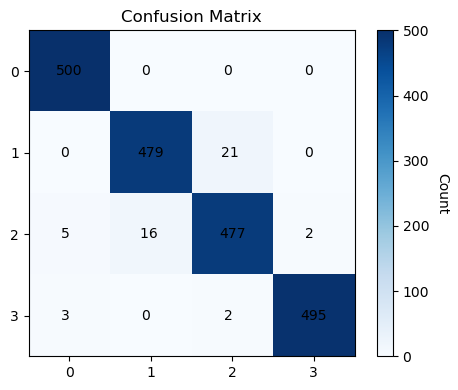

In [27]:
clean_cm = evaluate_with_confusion_matrix(clean_data, tree)

fold 1:
    accuracy = 0.905000
fold 2:
    accuracy = 0.915000
fold 3:
    accuracy = 0.905000
fold 4:
    accuracy = 0.930000
fold 5:
    accuracy = 0.860000
fold 6:
    accuracy = 0.865000
fold 7:
    accuracy = 0.900000
fold 8:
    accuracy = 0.875000
fold 9:
    accuracy = 0.910000
fold 10:
    accuracy = 0.880000
mean accuracy: 0.894500

Overall confusion matrix:




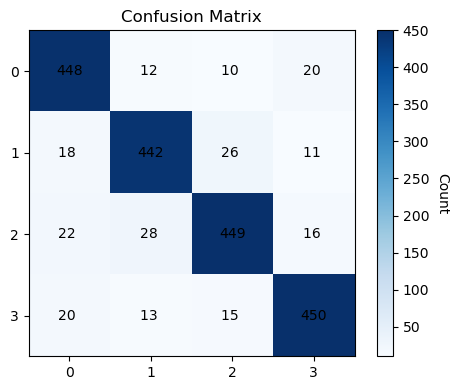

In [28]:
noisy_cm = evaluate_with_confusion_matrix(noisy_data, tree)


# other metrics

In [ ]:
def get_metrics_from_cm(cm):
  assert cm.shape[0] == cm.shape[1] and len(cm.shape) == 2
  num_class = cm.shape[0]
  for i in range(cm.shape[0]):
    print(f"class {i}:")

    TP = cm[i, i] # TP is the diagonal
    FP = cm[:, i].sum() - TP # those predicted to be label i except TP
    FN = cm[i, :].sum() - TP # those with real label i except TP
    TN = cm.sum() - (TP + FP + FN) # everything except the first three

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (TP + TN) / cm.sum()
    print(f"    accuracy  : {accuracy}")
    print(f"    precision : {precision}")
    print(f"    f1        : {f1}")
    print(f"    recall    : {recall}")
    print("\n\n")


In [30]:
get_metrics_from_cm(clean_cm)

class 0:
    accuracy  : [0.996 0.    0.    0.   ]
    precision : [0.98425197 0.         0.         0.        ]
    f1        : [0.99206349 0.         0.         0.        ]
    recall    : [1. 0. 0. 0.]



class 1:
    accuracy  : [0.     0.9815 0.     0.    ]
    precision : [0.         0.96767677 0.         0.        ]
    f1        : [0.         0.96281407 0.         0.        ]
    recall    : [0.    0.958 0.    0.   ]



class 2:
    accuracy  : [0.    0.    0.977 0.   ]
    precision : [0.    0.    0.954 0.   ]
    f1        : [0.    0.    0.954 0.   ]
    recall    : [0.    0.    0.954 0.   ]



class 3:
    accuracy  : [0.     0.     0.     0.9965]
    precision : [0.         0.         0.         0.99597586]
    f1        : [0.         0.         0.         0.99297894]
    recall    : [0.   0.   0.   0.99]





In [32]:
get_metrics_from_cm(noisy_cm)

class 0:
    accuracy  : [0.949 0.    0.    0.   ]
    precision : [0.88188976 0.         0.         0.        ]
    f1        : [0.89779559 0.         0.         0.        ]
    recall    : [0.91428571 0.         0.         0.        ]



class 1:
    accuracy  : [0.    0.946 0.    0.   ]
    precision : [0.         0.89292929 0.         0.        ]
    f1        : [0.         0.89112903 0.         0.        ]
    recall    : [0.         0.88933602 0.         0.        ]



class 2:
    accuracy  : [0.     0.     0.9415 0.    ]
    precision : [0.    0.    0.898 0.   ]
    f1        : [0.         0.         0.88472906 0.        ]
    recall    : [0.         0.         0.87184466 0.        ]



class 3:
    accuracy  : [0.     0.     0.     0.9525]
    precision : [0.        0.        0.        0.9054326]
    f1        : [0.         0.         0.         0.90452261]
    recall    : [0.         0.         0.         0.90361446]



